In [1]:
from pathlib import Path
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

#own modules
from evaluation.utils import db
from evaluation.processing import tools_ec
from evaluation.visualization import plot
con = db.connect()
'done' 

<IPython.core.display.Javascript object>

'done'

Link selected experiments to publication:  HTE02_Database
 For table exp_sfc : inserted new experiments = 0 , skipped existing experiments = 3 
Read data from "data_ec" ...
SELECT * FROM data_ec WHERE (`id_exp_sfc`) IN (7474, 7475, 7476) AND cycle IN (2);
Done in  0:00:00.041189
Link selected experiments to publication:  HTE02_Database
 For table exp_sfc : inserted new experiments = 0 , skipped existing experiments = 1 
Read data from "data_eis_analysis" ...
SELECT * FROM data_eis_analysis WHERE (`id_exp_sfc`) IN (7479);
Done in  0:00:00.022062
 Control quality of HFR extraction: 


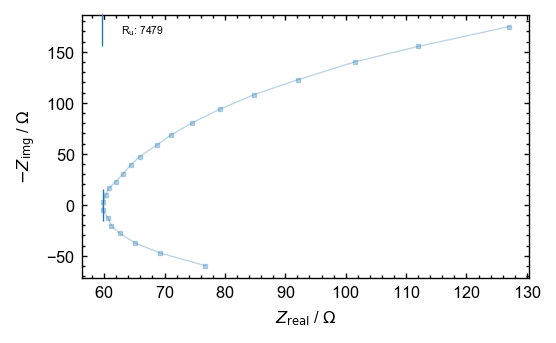

Matched experiment performed  9.887383333333334 min  earlier
Updated exp_ec with index: 7474 with ec_R_u_postdetermined__ohm= 59.8406  from id_exp_sfc= 7479
Link selected experiments to publication:  HTE02_Database
 For table exp_sfc : inserted new experiments = 0 , skipped existing experiments = 1 
Link selected experiments to publication:  HTE02_Database
 For table exp_sfc : inserted new experiments = 0 , skipped existing experiments = 1 
Read data from "data_eis_analysis" ...
SELECT * FROM data_eis_analysis WHERE (`id_exp_sfc`) IN (7479);
Done in  0:00:00.021911
 Control quality of HFR extraction: 


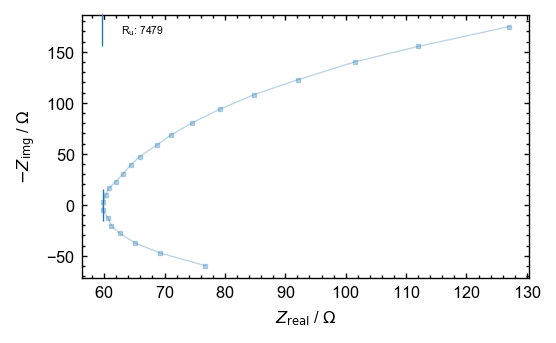

Matched experiment performed  8.743450000000001 min  earlier
Updated exp_ec with index: 7475 with ec_R_u_postdetermined__ohm= 59.8406  from id_exp_sfc= 7479
Link selected experiments to publication:  HTE02_Database
 For table exp_sfc : inserted new experiments = 0 , skipped existing experiments = 1 
Link selected experiments to publication:  HTE02_Database
 For table exp_sfc : inserted new experiments = 0 , skipped existing experiments = 1 
Read data from "data_eis_analysis" ...
SELECT * FROM data_eis_analysis WHERE (`id_exp_sfc`) IN (7479);
Done in  0:00:00.021856
 Control quality of HFR extraction: 


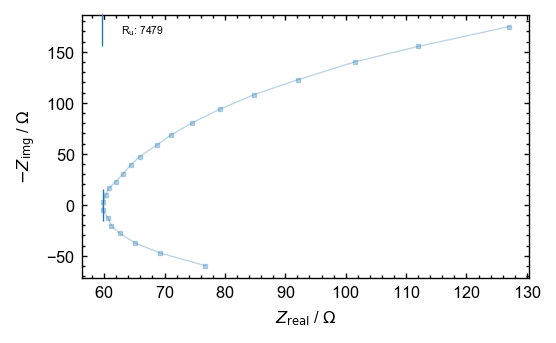

Matched experiment performed  6.436083333333333 min  earlier
Updated exp_ec with index: 7476 with ec_R_u_postdetermined__ohm= 59.8406  from id_exp_sfc= 7479
Link selected experiments to publication:  HTE02_Database
 For table exp_sfc : inserted new experiments = 0 , skipped existing experiments = 1 
 This is just a basic implementation of ECSA calculation for single CV cycle on Pt with constant capacitive current correction in acidic electrolyte. Be aware analysis procedure need to be adjusted for different electrode material, electrolyte, ... 
 This is just a basic implementation of ECSA calculation for single CV cycle on Pt with constant capacitive current correction in acidic electrolyte. Be aware analysis procedure need to be adjusted for different electrode material, electrolyte, ... 


/home/hte_admin/sciebo/jupyter/shared/04_modules/evaluation/visualization/plot.py:1196: UserWarning: y-axis label is overwritten from $I$ / A to I_capacitive__A
  warnings.warn('y-axis label is overwritten from ' + str(ax.get_ylabel()) + ' to ' + y_axislabel)


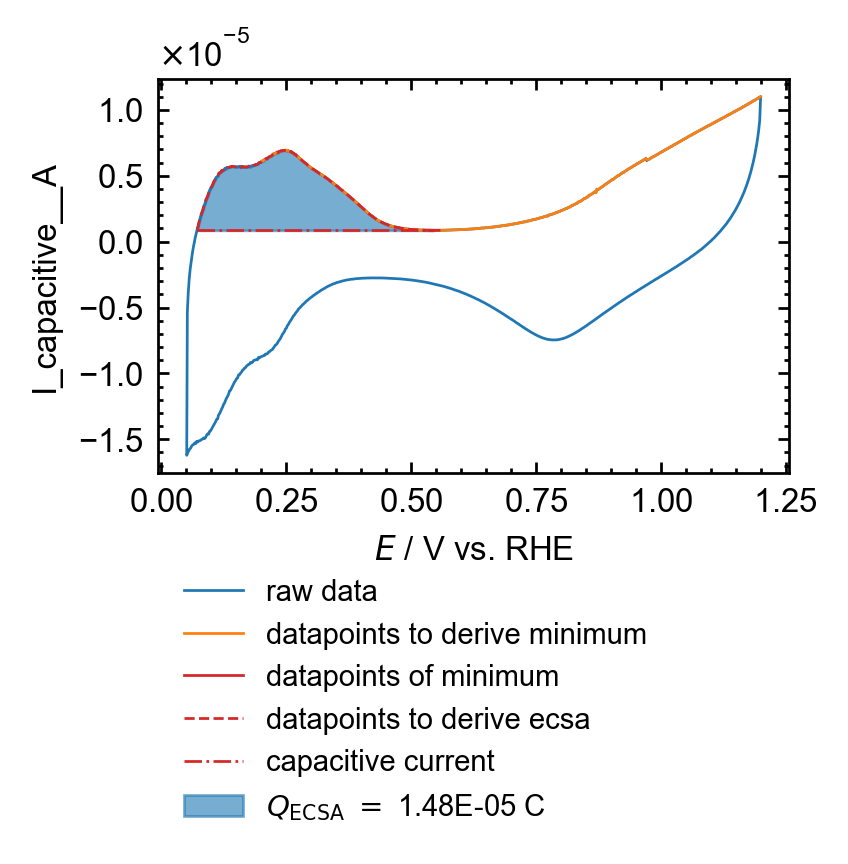

 This is just a basic implementation of ECSA calculation for single CV cycle on Pt with constant capacitive current correction in acidic electrolyte. Be aware analysis procedure need to be adjusted for different electrode material, electrolyte, ... 


/home/hte_admin/sciebo/jupyter/shared/04_modules/evaluation/visualization/plot.py:1196: UserWarning: y-axis label is overwritten from $I$ / A to I_capacitive__A
  warnings.warn('y-axis label is overwritten from ' + str(ax.get_ylabel()) + ' to ' + y_axislabel)


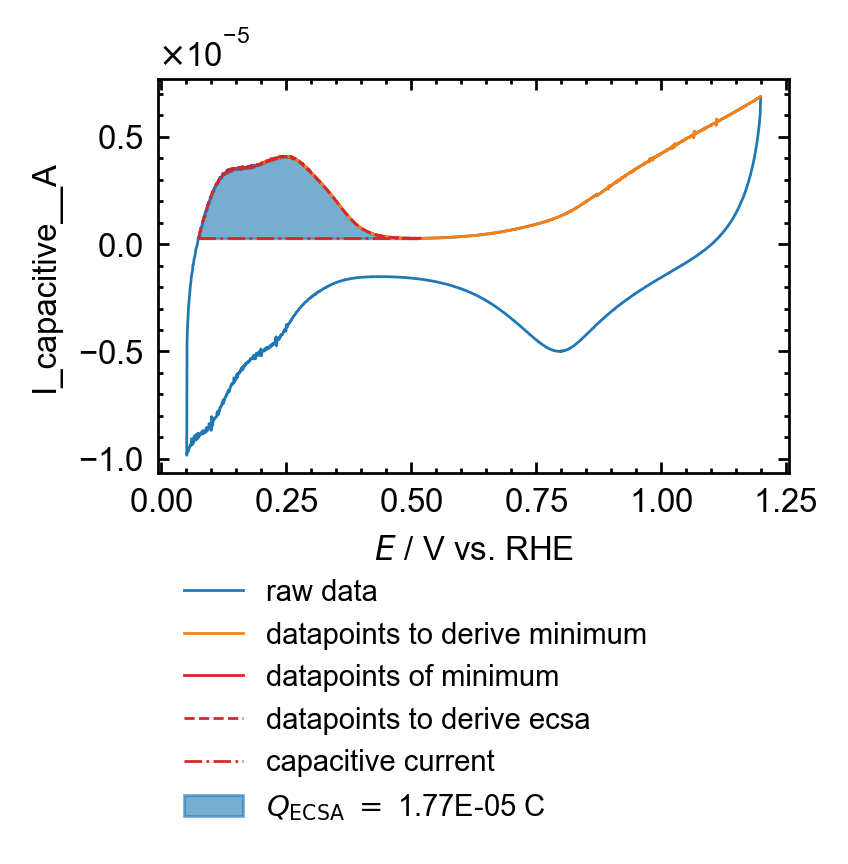

 This is just a basic implementation of ECSA calculation for single CV cycle on Pt with constant capacitive current correction in acidic electrolyte. Be aware analysis procedure need to be adjusted for different electrode material, electrolyte, ... 


/home/hte_admin/sciebo/jupyter/shared/04_modules/evaluation/visualization/plot.py:1196: UserWarning: y-axis label is overwritten from $I$ / A to I_capacitive__A
  warnings.warn('y-axis label is overwritten from ' + str(ax.get_ylabel()) + ' to ' + y_axislabel)


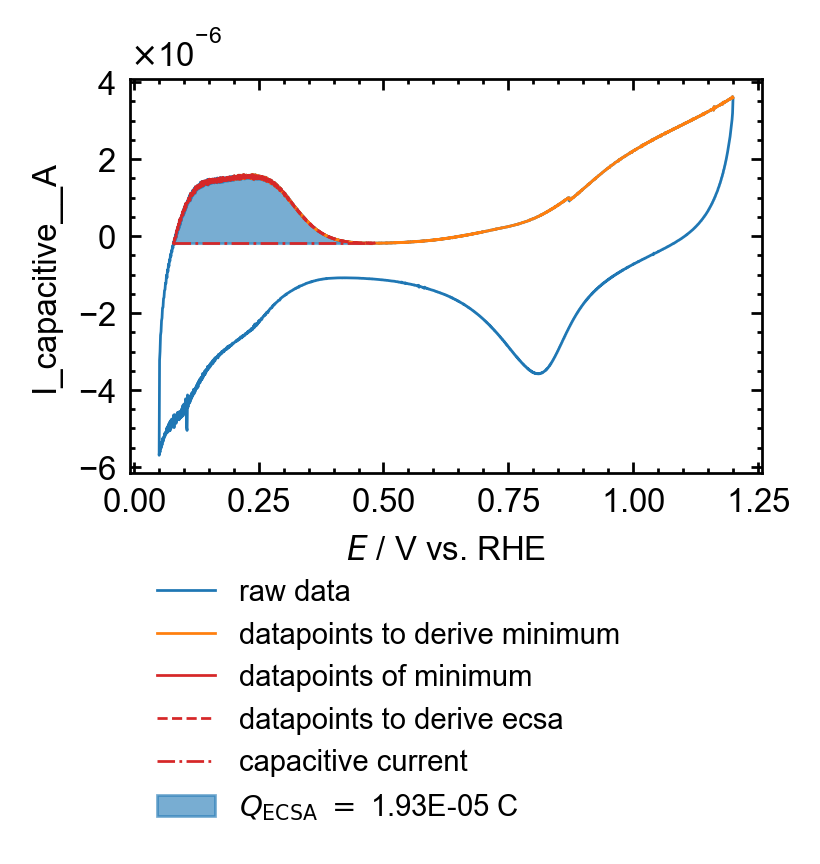

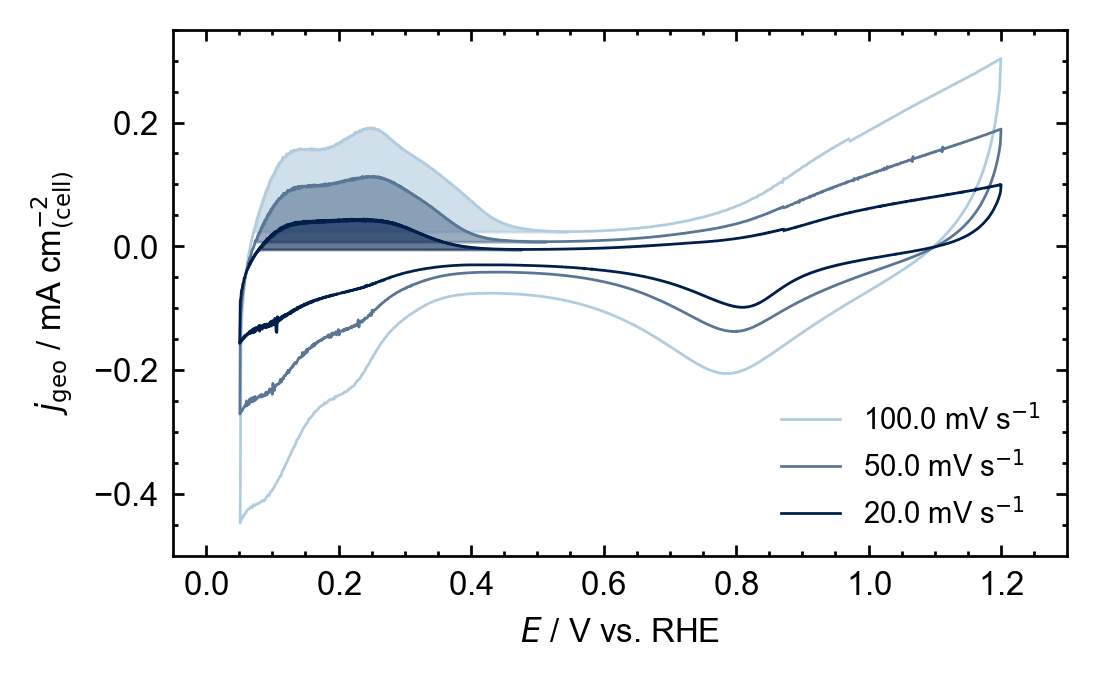

In [4]:
# query EC experiments based on metadata
exp_ec = db.get_exp('''SELECT  *
                        FROM hte_data.exp_ec_expanded 
                        WHERE name_user="n.roettcher"
                            AND name_setup_sfc = "SFC_1"
                            AND DATE(t_start__timestamp) = "2023-10-06"
                            AND fe_top_id_pump_out_device = 'SFC'  # not connected to ICP-MS
                            AND fe_top_pump_rate_out__rpm = 0  # no electrolyte flow
                            AND ec_name_technique="exp_ec_cv"
                            AND ROUND(cv_E_apex1__VvsRE + ec_E_RE__VvsRHE, 1) = 1.2  # or 1.6
                        ;
                        ''')


# query EC data based on selected experiments 
data_ec = db.get_data(exp_ec, 'data_ec', add_cond = 'cycle IN (2)')  

# apply HFR from EIS experiment performed in id_ML=61
exp_ec = tools_ec.update_R_u__ohm(exp_ec, match_eis_id_ML=61, user_control=False
                                 ) 
# calculate post-compensated potentials
data_ec = tools_ec.compensate_R_u(exp_ec, data_ec)  
# calculate geometric current density
data_ec = tools_ec.geometric_current(exp_ec, data_ec, geo_cols='fc_top_name_flow_cell_A_opening_ideal__mm2') 
# load samples composition from database and calculate gravimetric current density if applicable
exp_ec, data_ec = tools_ec.gravimetric_current(exp_ec, data_ec) 
# Derive ECSA applying Hupd method for Pt, fitting a horizontal line for the capacitive current
exp_ec, data_ec = tools_ec.derive_ECSA(exp_ec, data_ec, 
                                       method='Pt_Hupd_horizontal', 
                                       geo_cols='fc_top_name_flow_cell_A_opening_ideal__mm2')



# Apply our research group style template to the following matplotlib figure
with plt.rc_context(plot.get_style(style='singleColumn',
                                  add_margins_and_figsize= {'left': 0.1,  })):
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    exp_ec.dataset\
          .add_column(# Define the legend label for the experiments 
                      # based on the scanrate of the experiment
                      'label', 
                      values=exp_ec.cv_scanrate__mV_s.astype(str)+' mV s$^{-1}$')\
          .add_column(# Apply a colormap on the different experiments 
                      'color', 
                      values='pub_blues', 
                      cmap_min=0.3,
                      cmap_max=0.8)\
          .plot(# Plotting geometric current density vs compensated potential for all experiments
                x_col='E_WE__VvsRHE',
                y_col='j__mA_cm2geo_fc_top_cell_Aideal',
                data=data_ec,  
                ax=ax1,
                )\
          .fill_between(# Fill the area between total current and capacitive current
                        # as derived from ECSA tool indicating the faradaic charge
                        x_col='E_WE__VvsRHE',
                        y_col= 'j_capacitive__mA_cm2geo_fc_top_cell_Aideal',
                        y2_col = 'j__mA_cm2geo_fc_top_cell_Aideal',
                        data=data_ec,    
                        ax=ax1,
                        label='',
                        alpha=0.6,
                        axlabel_auto=False,   
                        )
    ax1.legend()
    ax1.set_ylim([-0.5, 0.35])
    ax1.set_xlim([-0.05, 1.3])
    fig.savefig('20231013_visualization.pdf')
    plt.show()

        
# Check whether experimental metadata is the same for all three experiments 
# cv_scanrate__mV_s will obviously be different
# but for example cv_E_initial__VvsRE the initial potential of the cv is different
exp_ec.dataset.display(only_different_cols=True)